In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.cluster import KMeans

sns.set(style="whitegrid")
plt.rcParams.update({"figure.dpi": 110})



In [2]:
# 기본적 eda

In [3]:
# ============================================================
# 0. Path 및 데이터 로드
# ============================================================
BASE_DIR = Path.cwd().resolve()
DATA_PATH = BASE_DIR.parents[1] / "data" / "raw" / "train.csv"

df = pd.read_csv(DATA_PATH)
print("Loaded:", df.shape)


Loaded: (10836, 9)


In [4]:
# ============================================================
# 1. 기본 타입 변환
# ============================================================
df["year"] = df["year"].astype(int)
df["month"] = df["month"].astype(int)
df["seq"] = df["seq"].astype(int)
df["type"] = df["type"].astype(str)
df["hs4"] = df["hs4"].astype(str).str.zfill(4)

df["weight"] = df["weight"].astype(float)
df["quantity"] = df["quantity"].astype(float)
df["value"] = df["value"].astype(float)

print(df.dtypes)


item_id      object
year          int64
month         int64
seq           int64
type         object
hs4          object
weight      float64
quantity    float64
value       float64
dtype: object



=== Missing Value Summary ===
item_id     0
year        0
month       0
seq         0
type        0
hs4         0
weight      0
quantity    0
value       0
dtype: int64


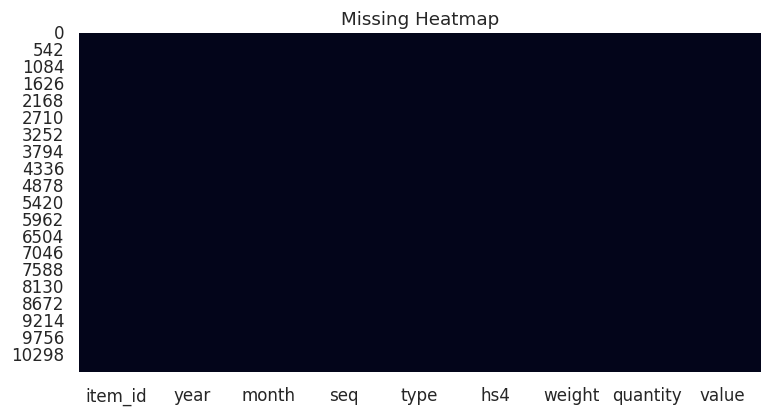

In [5]:
# ============================================================
# 2. 결측치 EDA
# ============================================================
print("\n=== Missing Value Summary ===")
print(df.isna().sum())

plt.figure(figsize=(8,4))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Heatmap")
plt.show()


In [6]:
# ============================================================
# 3. 기본 통계
# ============================================================
print("\n=== Describe ===")
print(df[["weight", "quantity", "value"]].describe())



=== Describe ===
             weight      quantity         value
count  1.083600e+04  1.083600e+04  1.083600e+04
mean   1.098413e+06  8.633771e+04  1.739442e+06
std    5.153790e+06  7.614669e+06  5.457480e+06
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    3.457500e+02  0.000000e+00  1.150675e+04
50%    6.532500e+03  0.000000e+00  1.250070e+05
75%    1.555108e+05  0.000000e+00  1.039764e+06
max    1.104919e+08  7.925990e+08  1.110414e+08


In [7]:
# ============================================================
# 4. 음수값/이상치 탐색
# ============================================================
neg_mask = (df["weight"] < 0) | (df["quantity"] < 0) | (df["value"] < 0)
print("Negative count:", neg_mask.sum())

# value=0 & weight>0, weight=0 & value>0
c1 = df[(df["value"] == 0) & (df["weight"] > 0)]
c2 = df[(df["weight"] == 0) & (df["value"] > 0)]
print("value=0 & weight>0:", len(c1))
print("weight=0 & value>0:", len(c2))


Negative count: 0
value=0 & weight>0: 1
weight=0 & value>0: 300


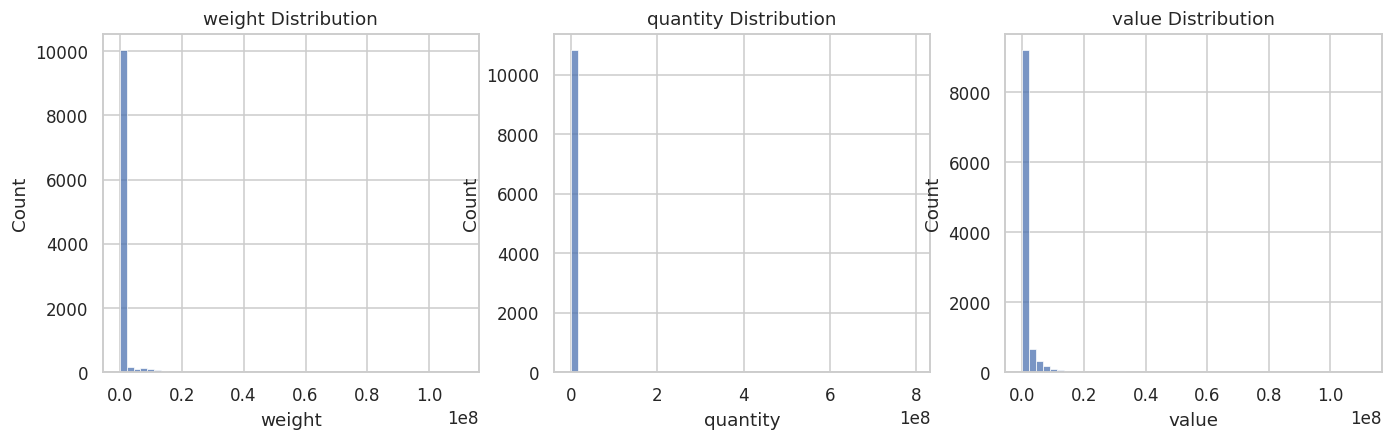

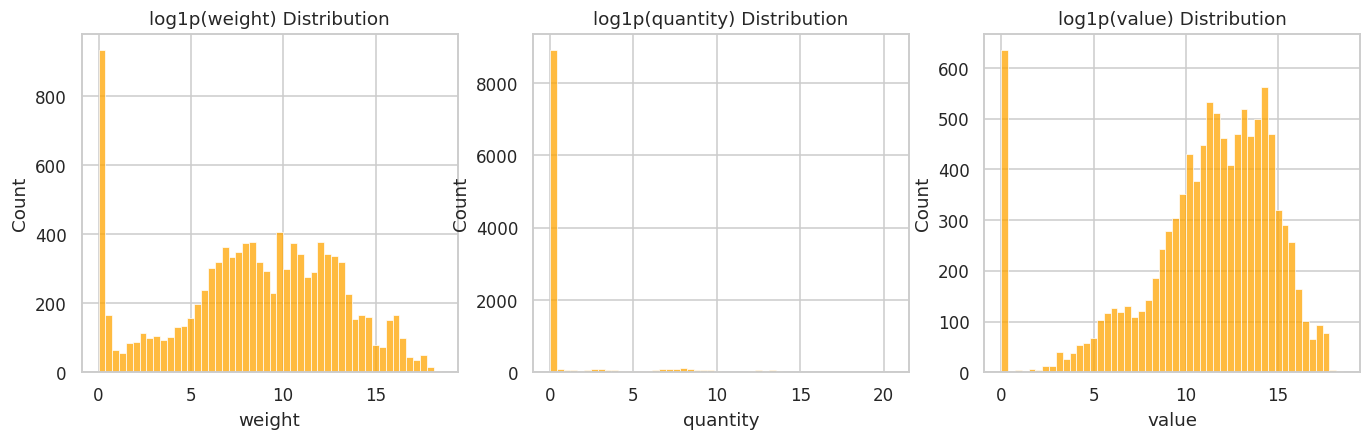

In [8]:
# ============================================================
# 5. 분포 확인
# ============================================================
num_cols = ["weight", "quantity", "value"]

fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, c in enumerate(num_cols):
    sns.histplot(df[c], bins=50, ax=axes[i])
    axes[i].set_title(f"{c} Distribution")
plt.show()

# 로그 분포
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, c in enumerate(num_cols):
    sns.histplot(np.log1p(df[c]), bins=50, ax=axes[i], color="orange")
    axes[i].set_title(f"log1p({c}) Distribution")
plt.show()


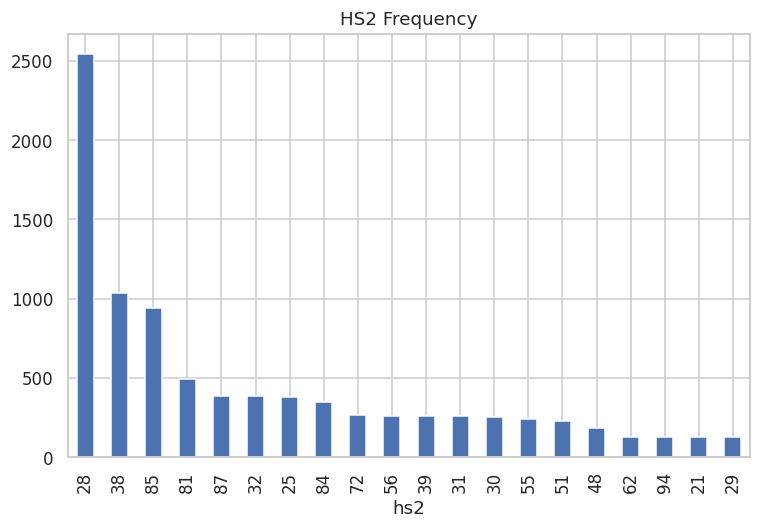

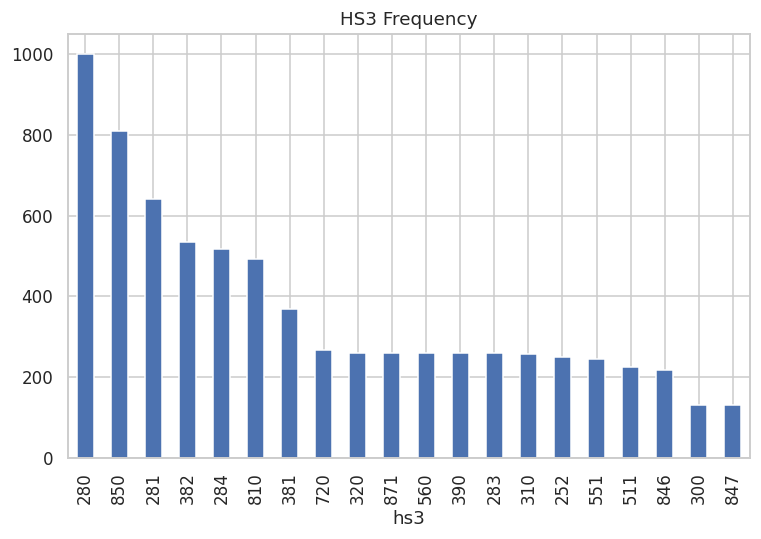

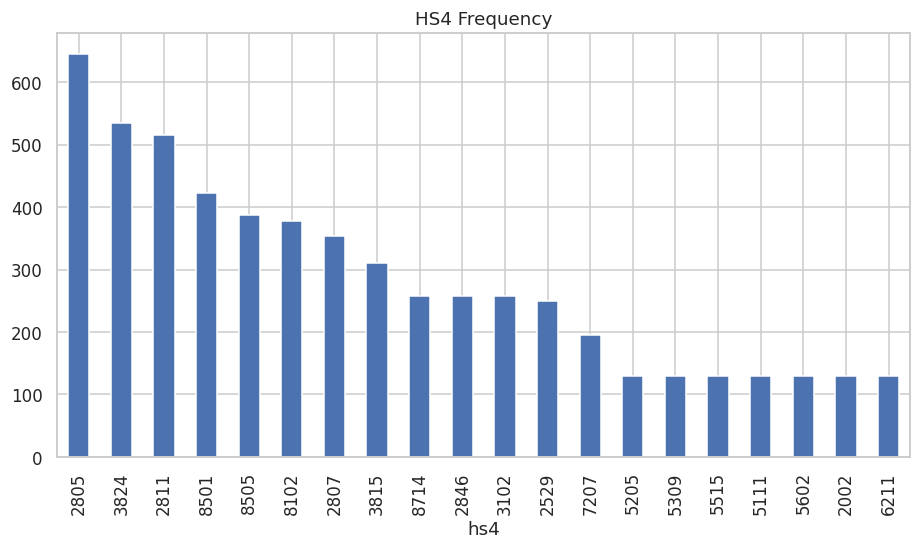

In [9]:
# ============================================================
# 6. HS Code EDA
# ============================================================
df["hs2"] = df["hs4"].str[:2]
df["hs3"] = df["hs4"].str[:3]

plt.figure(figsize=(8,5))
df["hs2"].value_counts().head(20).plot(kind="bar")
plt.title("HS2 Frequency")
plt.show()

plt.figure(figsize=(8,5))
df["hs3"].value_counts().head(20).plot(kind="bar")
plt.title("HS3 Frequency")
plt.show()

plt.figure(figsize=(10,5))
df["hs4"].value_counts().head(20).plot(kind="bar")
plt.title("HS4 Frequency")
plt.show()


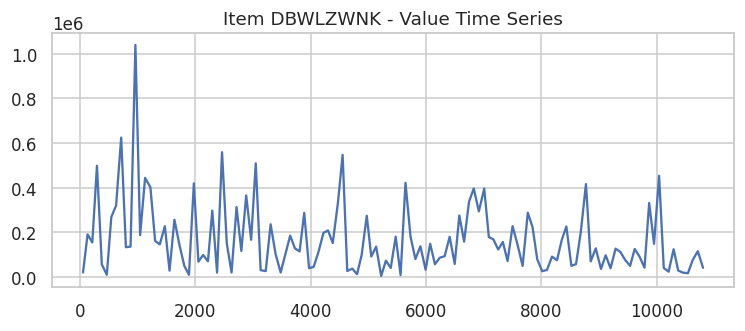

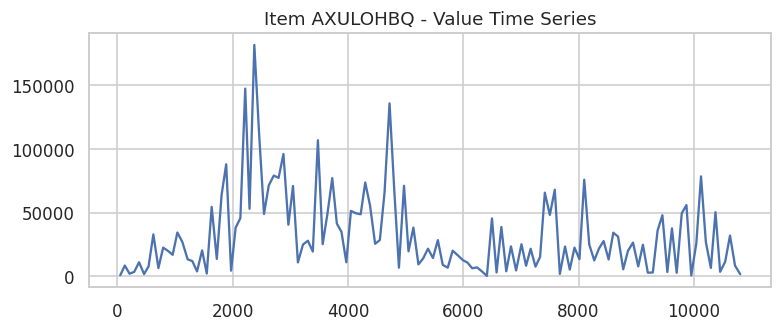

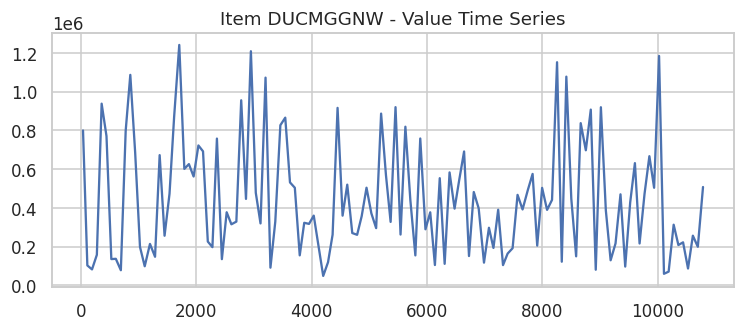

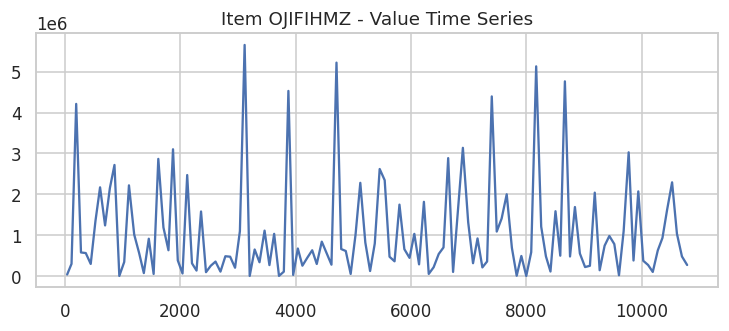

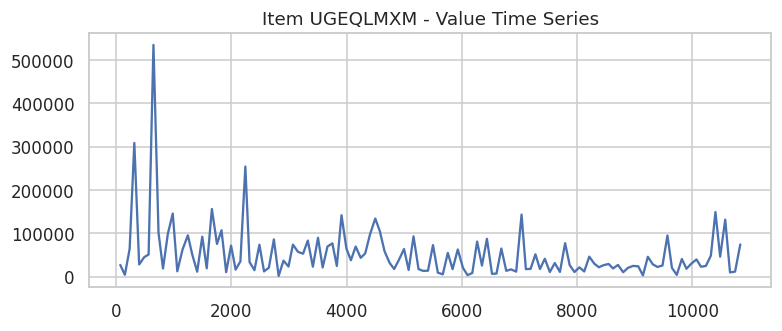

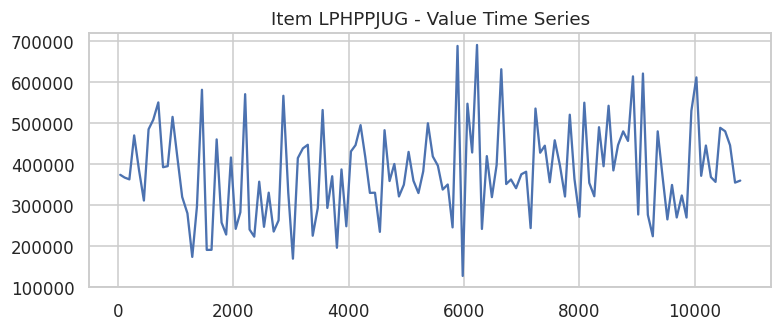

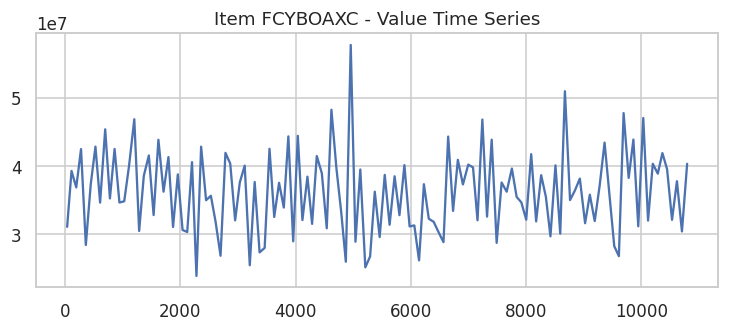

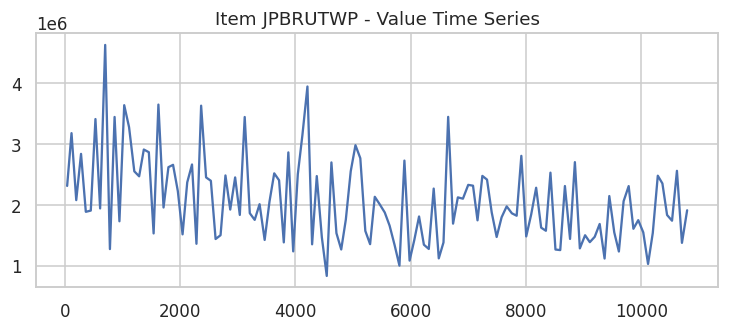

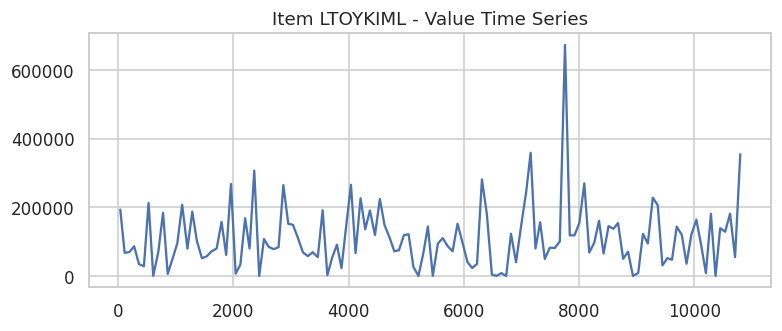

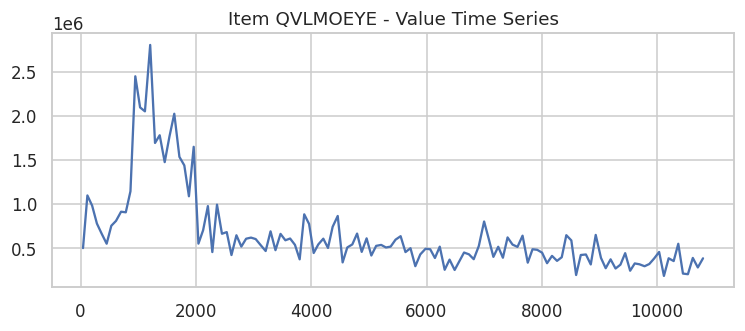

In [10]:
# ============================================================
# 7. item별 시계열 구조 분석
# ============================================================
# sample 10개 item만 비교
sample_items = df["item_id"].value_counts().head(10).index

for item in sample_items:
    tmp = df[df["item_id"] == item].sort_values(["year","month"])
    plt.figure(figsize=(8,3))
    plt.plot(tmp["value"])
    plt.title(f"Item {item} - Value Time Series")
    plt.show()


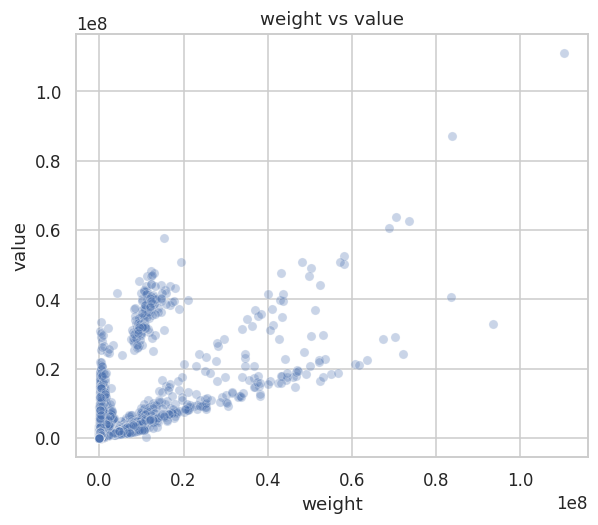

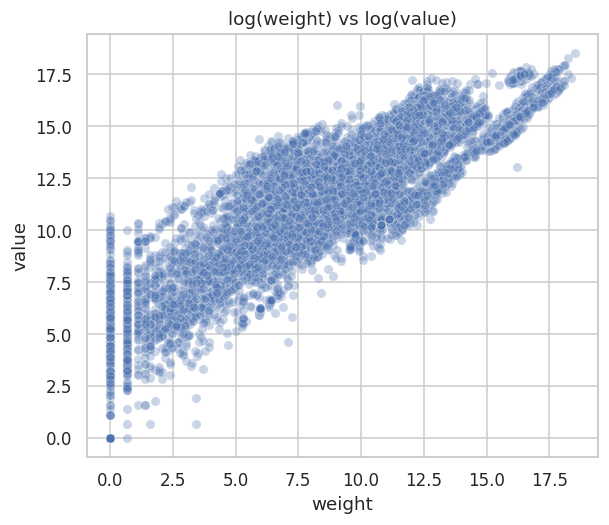

In [11]:
# ============================================================
# 8. value/weight 관계 구조
# ============================================================
plt.figure(figsize=(6,5))
sns.scatterplot(x=df["weight"], y=df["value"], alpha=0.3)
plt.title("weight vs value")
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x=np.log1p(df["weight"]), y=np.log1p(df["value"]), alpha=0.3)
plt.title("log(weight) vs log(value)")
plt.show()



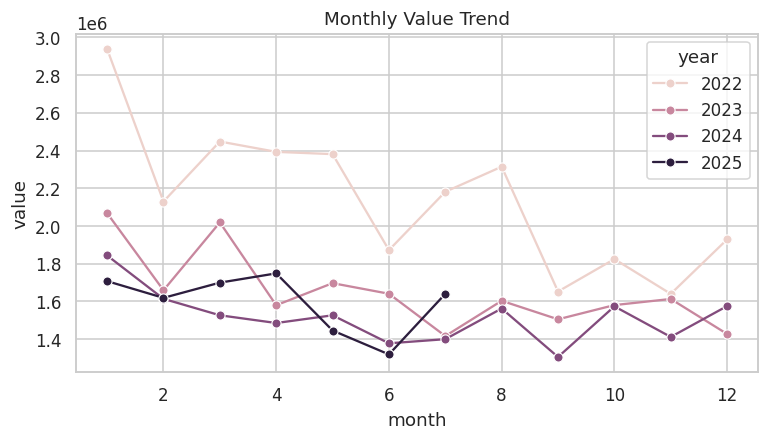

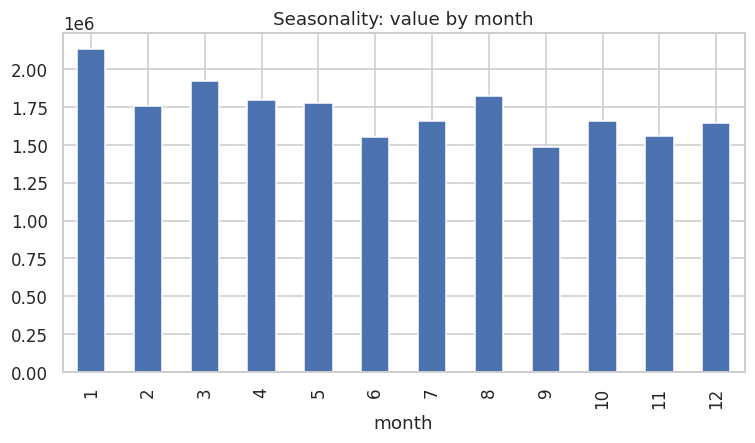

In [12]:
# ============================================================
# 9. 월별 패턴 (seasonality)
# ============================================================
ym = df.groupby(["year", "month"])["value"].mean().reset_index()
plt.figure(figsize=(8,4))
sns.lineplot(data=ym, x="month", y="value", hue="year", marker="o")
plt.title("Monthly Value Trend")
plt.show()

month_mean = df.groupby("month")["value"].mean()
month_mean.plot(kind="bar", figsize=(8,4))
plt.title("Seasonality: value by month")
plt.show()




In [13]:
# ============================================================
# 10. seq EDA
# ============================================================
seq_check = (
    df.groupby(["item_id","year","month","type","hs4"])
      .agg(seq_count=("seq","nunique"))
      .reset_index()
)

print("SEQ count >1:", (seq_check["seq_count"] > 1).sum())
print(seq_check[seq_check["seq_count"] > 1].head())



SEQ count >1: 3655
    item_id  year  month type   hs4  seq_count
0  AANGBULD  2022      1    1  4810          2
2  AANGBULD  2022      3    1  4810          2
3  AANGBULD  2022      5    1  4810          2
4  AANGBULD  2022      6    1  4810          3
7  AANGBULD  2023      2    1  4810          3


In [14]:
# ============================================================
# 11. rare item 탐지
# ============================================================
item_total = df.groupby("item_id")["value"].sum().sort_values()
rare_items = item_total[item_total < item_total.quantile(0.05)]
print("\nRare items count:", len(rare_items))
print(rare_items.head())



Rare items count: 5
item_id
RUVXNNVA     278.0
GMBFCMIU    1130.0
QSDCUCLB    2793.0
TANNMIMB    4338.0
PLMZALFA    5385.0
Name: value, dtype: float64


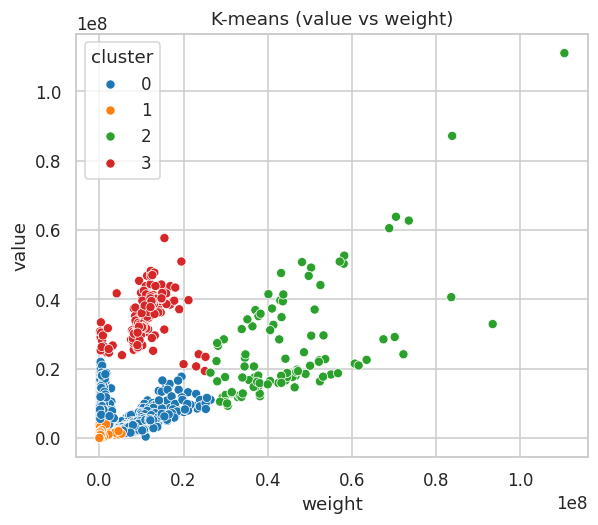

In [16]:
# ============================================================
# 12. K-means 군집 가능성 테스트 (value, weight)
# ============================================================
sample = df[["weight","value"]].replace([np.inf,-np.inf], np.nan).dropna()

kmeans = KMeans(n_clusters=4, random_state=42).fit(sample)
sample["cluster"] = kmeans.labels_

plt.figure(figsize=(6,5))
sns.scatterplot(x=sample["weight"], y=sample["value"], hue=sample["cluster"], palette="tab10")
plt.title("K-means (value vs weight)")
plt.show()

# cluster 0: 극소량/저가, cluster 1: 극저량/초저가, cluster 2: 고중량/고가, cluster 3: 중간 영역
